In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import rebound
import reboundx
import time
from ctypes import cdll
from scipy.integrate import quad
from scipy.special import gamma, spence
from scipy.optimize import minimize_scalar
from numba import jit
import scipy.odr as odr
from Burkert_profile_functions import *
from NFW_profile_functions import *
from Sersic_profile_functions import *
import os
import shutil

# matplotlib setup
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['figure.facecolor'] = 'white'
#plt.rc('text', usetex=True)
#plt.rc('font', family='serif',size=15)
plt.rc('axes', linewidth=1.5)
plt.rc('axes', labelsize=15)
plt.rc('xtick', labelsize=15, direction='in')
plt.rc('ytick', labelsize=15, direction='in')
plt.rc('xtick', top=True)
plt.rc('ytick', right=True)
plt.rc('xtick.minor', visible=True)
plt.rc('ytick.minor', visible=True)
plt.rc('xtick.major',size=10, pad=4)
plt.rc('xtick.minor',size=5, pad=4)
plt.rc('ytick.major',size=10)
plt.rc('ytick.minor',size=5)
plt.rc('legend', fontsize=15)

# masses of the GCs from the Georgiev catalogue in units of 1e5 solar masses
UGC7369_masses = np.array([ 0.5270876 ,  0.15333488,  1.08466861,  0.23894274,  0.53477108,
        0.66067185,  2.74824974, 43.7230426 ,  0.25702028,  0.68325756,
        0.48945594,  0.78176033,  0.98889862,  0.70596634,  1.74467125,
        1.42423357,  1.17664156,  0.49028781,  0.71836984,  0.42620355,
        0.33863009])
# total mass in GCs
UGC7369_total_mass = sum(UGC7369_masses)
UGC8638_total_mass = 31.8 
NGC4605_total_mass = 14.33
# UGC 7369 effective (half-light) radius in kpc
#UGC7369_R_e = 0.90
# projected separation divided by effective radius from Georgiev
#UGC7369_rperps_norms =  np.array([2.23066667, 1.428     , 0.99866667, 1.96933333, 1.97866667,
      # 0.63466667, 0.13066667, 0.00933333, 0.24266667, 0.364     ,
       #1.372     , 0.42      , 0.644     , 0.37333333, 0.42      ,
       #0.82133333, 0.99866667, 1.77333333, 0.868     , 1.148     ,
       #1.22266667])
# physical projected radii
#UGC7369_rperps = UGC7369_rperps_norms*UGC7369_R_e

# a C implementation of friction and background forces in rebound, for speed
clib_additional_forces = cdll.LoadLibrary("/home/vk9342/USRP2023/additional_forces.so")

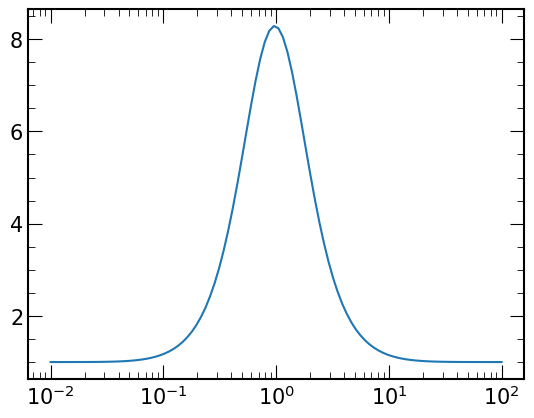

In [2]:
# mass function: gaussian in logM, mean/variance taken from Georgiev catalogue normal dist fit
def mass_function(logmass):
    # currently using a NSC cut fit
    mean = 4.987311450993631 - 5
    variance = 0.18871641457327373
    return 1/np.sqrt(2*np.pi*variance) * np.exp(-(logmass-mean)**2 / (2*variance))

# testing it out with a plot of the mass function
test_masses = np.logspace(-2, 2, 100)
plt.plot(test_masses, 10**mass_function(np.log10(test_masses)))
plt.xscale('log')
plt.show()

# custom merge function
def merge_energy(sim_pointer, collided_particles_index):
    sim = sim_pointer.contents
    ps = sim.particles
    
    i = collided_particles_index.p1
    j = collided_particles_index.p2
    
    # calculating the relevant energy to see if a merger really should happen or not
    dp = ps[i]-ps[j]
    total_mass = ps[i].m + ps[j].m
    reduced_mass = (ps[i].m*ps[j].m)/total_mass
    r_12 = np.sqrt(dp.x**2 + dp.y**2 + dp.z**2)
    v_12sq = dp.vx**2 + dp.vy**2 + dp.vz**2
    U_12 = -sim.G*ps[i].m*ps[j].m / (r_12**2.11 + (1.7*sim.softening)**2.11)**(1/2.11)
    E_12 = 0.5*reduced_mass*v_12sq + U_12
    #print('merge function called')
    if E_12 < 0:
        # if clusters did meet the energy condition, delete particle j and update particle i to the merged one
        #print(np.sqrt(ps[i].x**2 + ps[i].y**2 + ps[i].z**2), dp.vx, dp.vy, dp.vz)
        old_radius = ps[i].r
        new_particle = (ps[i]*ps[i].m + ps[j]*ps[j].m)/total_mass
        ps[i] = new_particle
        ps[i].m = total_mass
        ps[i].r = 2*2.548e-3*(total_mass/0.1)**(0.242)
        return 2
    else:
        # in case the clusters did pass near each other, but didn't meet the energy condition, do nothing
        return 0

Calculating NFW Energies and Weights


<ipython-input-4-e445635a3491>:27: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]


Finished calculating NFW Energies and Weights
9.006072998046875
1.7 0.1
finished until t = 0.0 0.879091739654541


/home/vk9342/.local/lib/python3.8/site-packages/rebound/simulation.py:1032: RuntimeWarning: At least 10 predictor corrector loops in IAS15 did not converge. This is typically an indication of the timestep being too large.
  warnings.warn(msg[1:], RuntimeWarning)


finished until t = 0.5 5.453341245651245
finished until t = 1.0 12.429490089416504
finished until t = 1.5 21.72758197784424
finished until t = 2.0 32.42971181869507
finished until t = 2.5 44.78106212615967
finished until t = 3.0 59.0175838470459
finished until t = 3.5 74.43382143974304
finished until t = 4.0 91.16359877586365
finished until t = 4.5 108.85493350028992
finished until t = 5.0 127.699209690094
finished until t = 5.5 148.50999474525452
finished until t = 6.0 170.41183352470398
finished until t = 6.5 195.74444818496704
finished until t = 7.0 223.24255394935608
finished until t = 7.5 252.07025861740112
finished until t = 8.0 282.0985722541809
finished until t = 8.5 313.74653601646423
finished until t = 9.0 350.63813948631287
finished until t = 9.5 389.61913561820984
finished until t = 10.0 429.4743092060089


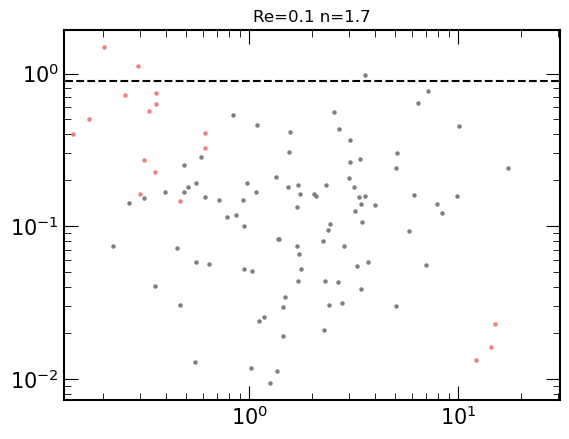

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.488497972488403
1.7 0.3
finished until t = 0.0 0.6334090232849121
finished until t = 0.5 6.809345722198486
finished until t = 1.0 17.701452493667603
finished until t = 1.5 33.6240918636322
finished until t = 2.0 54.030699491500854
finished until t = 2.5 78.9283697605133
finished until t = 3.0 107.2266218662262
finished until t = 3.5 139.40852856636047
finished until t = 4.0 174.68249583244324
finished until t = 4.5 213.71270298957825
finished until t = 5.0 255.89429759979248
finished until t = 5.5 300.7164475917816
finished until t = 6.0 348.08571004867554
finished until t = 6.5 398.99888825416565
finished until t = 7.0 451.95403933525085
finished until t = 7.5 507.59575867652893
finished until t = 8.0 566.4436197280884
finished until t = 8.5 627.5855286121368
finished until t = 9.0 691.0493412017822
finished until t = 9.5 757.2211122512817
finished until t = 10.0 826.2072274684906


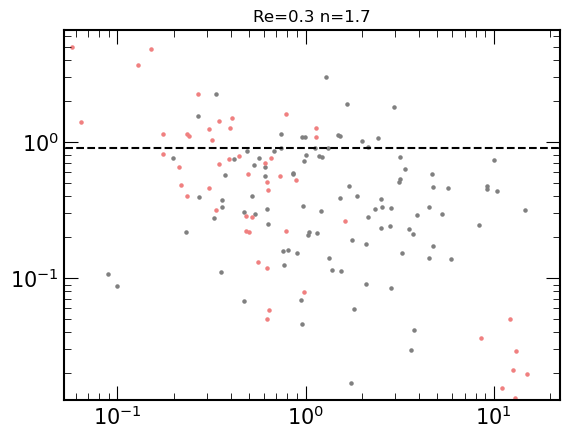

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.810334920883179
1.7 0.5
finished until t = 0.0 0.7135939598083496
finished until t = 0.5 6.3486247062683105
finished until t = 1.0 16.69002938270569
finished until t = 1.5 32.03626775741577
finished until t = 2.0 52.287128925323486
finished until t = 2.5 77.40027093887329
finished until t = 3.0 107.54199647903442
finished until t = 3.5 142.25139093399048
finished until t = 4.0 180.71220326423645
finished until t = 4.5 223.63050961494446
finished until t = 5.0 272.3006343841553
finished until t = 5.5 324.3191337585449
finished until t = 6.0 380.9270453453064
finished until t = 6.5 441.6509208679199
finished until t = 7.0 506.5253019332886
finished until t = 7.5 576.7239019870758
finished until t = 8.0 651.3071990013123
finished until t = 8.5 729.89124584198
finished until t = 9.0 811.4292106628418
finished until t = 9.5 897.0456314086914
finished until t = 10.0 986.2215414047241


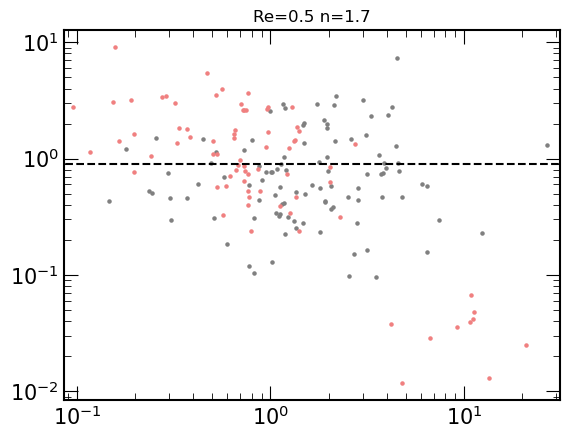

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.10301160812378
1.7 0.7
finished until t = 0.0 0.6080946922302246
finished until t = 0.5 5.491203546524048
finished until t = 1.0 14.084343194961548
finished until t = 1.5 26.877607822418213
finished until t = 2.0 43.60530233383179
finished until t = 2.5 65.09489846229553
finished until t = 3.0 91.02892875671387
finished until t = 3.5 121.6452329158783
finished until t = 4.0 156.20785808563232
finished until t = 4.5 196.3328719139099
finished until t = 5.0 240.85048913955688
finished until t = 5.5 289.0832929611206
finished until t = 6.0 341.9190483093262
finished until t = 6.5 399.54200530052185
finished until t = 7.0 461.78947401046753
finished until t = 7.5 526.4838082790375
finished until t = 8.0 595.9388265609741
finished until t = 8.5 671.041755437851
finished until t = 9.0 747.7894659042358
finished until t = 9.5 828.6177868843079
finished until t = 10.0 912.9762654304504


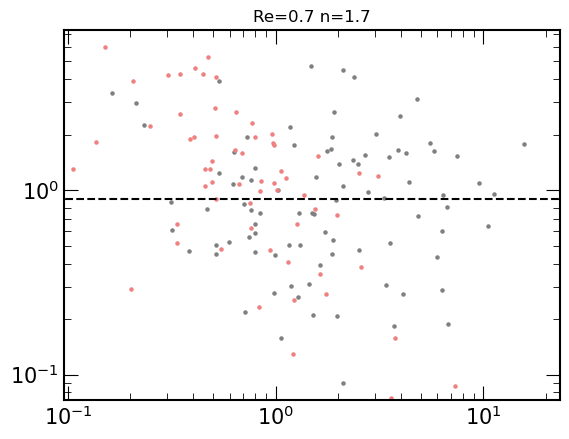

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.181471347808838
1.7 0.9
finished until t = 0.0 0.7664945125579834
finished until t = 0.5 6.283605337142944
finished until t = 1.0 16.95762610435486
finished until t = 1.5 32.782636880874634
finished until t = 2.0 53.29159450531006
finished until t = 2.5 79.2698667049408
finished until t = 3.0 110.31575989723206
finished until t = 3.5 147.4177165031433
finished until t = 4.0 189.61412978172302
finished until t = 4.5 237.61180233955383
finished until t = 5.0 289.9087038040161
finished until t = 5.5 345.3120548725128
finished until t = 6.0 405.52406334877014
finished until t = 6.5 470.5044584274292
finished until t = 7.0 540.4246611595154
finished until t = 7.5 614.9919619560242
finished until t = 8.0 693.7913897037506
finished until t = 8.5 777.0334091186523
finished until t = 9.0 864.4288353919983
finished until t = 9.5 956.8346498012543
finished until t = 10.0 1053.5201394557953


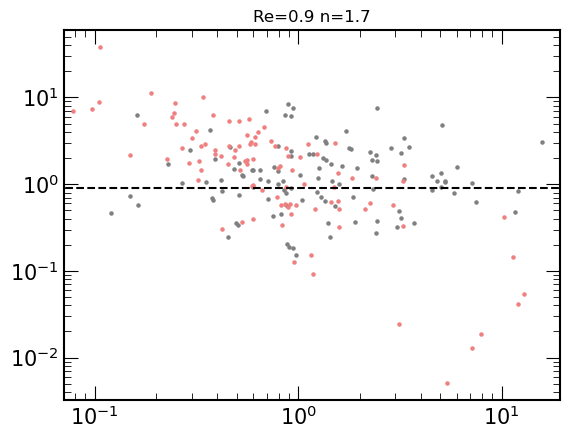

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.120155811309814
1.7 1.1
finished until t = 0.0 0.6188886165618896
finished until t = 0.5 4.883228302001953
finished until t = 1.0 12.884822845458984
finished until t = 1.5 24.68711233139038
finished until t = 2.0 41.47273540496826
finished until t = 2.5 61.46970725059509
finished until t = 3.0 85.31405186653137
finished until t = 3.5 113.51590418815613
finished until t = 4.0 145.39006757736206
finished until t = 4.5 181.2783818244934
finished until t = 5.0 220.9803168773651
finished until t = 5.5 266.2260801792145
finished until t = 6.0 315.029013633728
finished until t = 6.5 366.8974573612213
finished until t = 7.0 425.59973096847534
finished until t = 7.5 485.9590482711792
finished until t = 8.0 549.3182525634766
finished until t = 8.5 618.2122230529785
finished until t = 9.0 691.2241325378418
finished until t = 9.5 766.813818693161
finished until t = 10.0 846.2229330539703


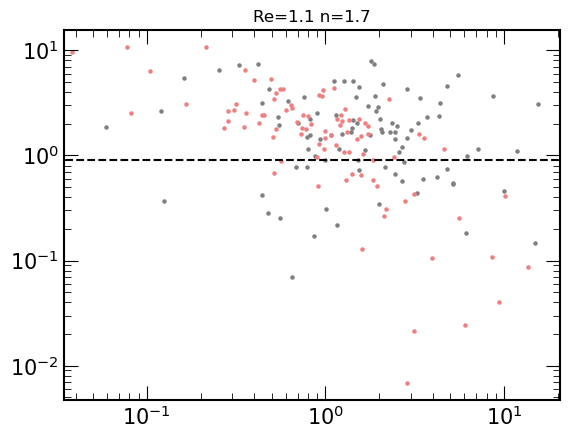

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.297891616821289
1.7 1.3
finished until t = 0.0 0.5471677780151367
finished until t = 0.5 4.00096321105957
finished until t = 1.0 10.329246759414673
finished until t = 1.5 19.55025553703308
finished until t = 2.0 31.789002895355225
finished until t = 2.5 47.14635610580444
finished until t = 3.0 65.79496932029724
finished until t = 3.5 87.79218316078186
finished until t = 4.0 113.17988109588623
finished until t = 4.5 141.9983148574829
finished until t = 5.0 174.38746285438538
finished until t = 5.5 210.18485116958618
finished until t = 6.0 249.34622955322266
finished until t = 6.5 291.82214283943176
finished until t = 7.0 337.5503134727478
finished until t = 7.5 386.3257989883423
finished until t = 8.0 438.133327960968
finished until t = 8.5 493.34072399139404
finished until t = 9.0 551.7941961288452
finished until t = 9.5 613.3343935012817
finished until t = 10.0 678.6315104961395


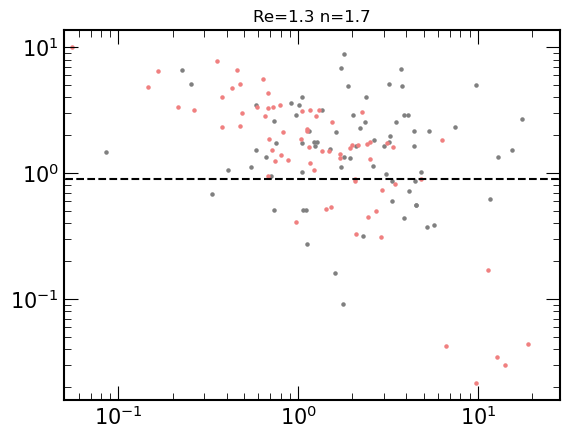

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.94426941871643
1.7 1.5
finished until t = 0.0 0.6166598796844482
finished until t = 0.5 4.823507070541382
finished until t = 1.0 12.707695960998535
finished until t = 1.5 24.3922438621521
finished until t = 2.0 39.72001576423645
finished until t = 2.5 58.75506782531738
finished until t = 3.0 81.87940096855164
finished until t = 3.5 108.33100175857544
finished until t = 4.0 138.49723434448242
finished until t = 4.5 172.71586227416992
finished until t = 5.0 211.0938482284546
finished until t = 5.5 253.5338532924652
finished until t = 6.0 300.24396085739136
finished until t = 6.5 351.18199038505554
finished until t = 7.0 406.4352238178253
finished until t = 7.5 465.39084458351135
finished until t = 8.0 528.4851551055908
finished until t = 8.5 595.0507469177246
finished until t = 9.0 665.4845395088196
finished until t = 9.5 739.6925668716431
finished until t = 10.0 817.5949892997742


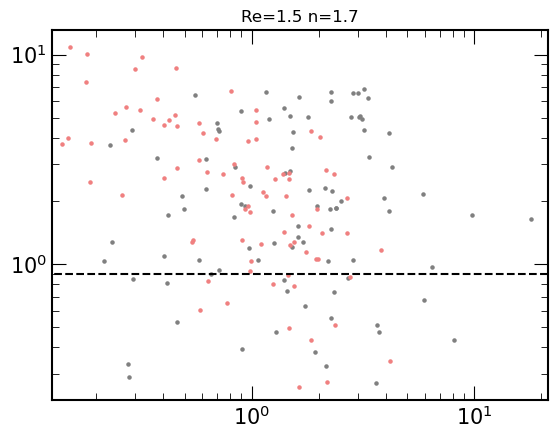

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.603219509124756
1.7 1.7
finished until t = 0.0 0.5909919738769531
finished until t = 0.5 4.353268623352051
finished until t = 1.0 11.451381206512451
finished until t = 1.5 21.782832145690918
finished until t = 2.0 35.28845691680908
finished until t = 2.5 51.997955322265625
finished until t = 3.0 72.084055185318
finished until t = 3.5 95.64664220809937
finished until t = 4.0 120.79695081710815
finished until t = 4.5 148.33975100517273
finished until t = 5.0 178.92009091377258
finished until t = 5.5 212.75285387039185
finished until t = 6.0 249.86254405975342
finished until t = 6.5 290.04850697517395
finished until t = 7.0 333.30185985565186
finished until t = 7.5 379.6561641693115
finished until t = 8.0 429.2868776321411
finished until t = 8.5 481.71533012390137
finished until t = 9.0 537.6040513515472
finished until t = 9.5 596.6624155044556
finished until t = 10.0 659.4010624885559


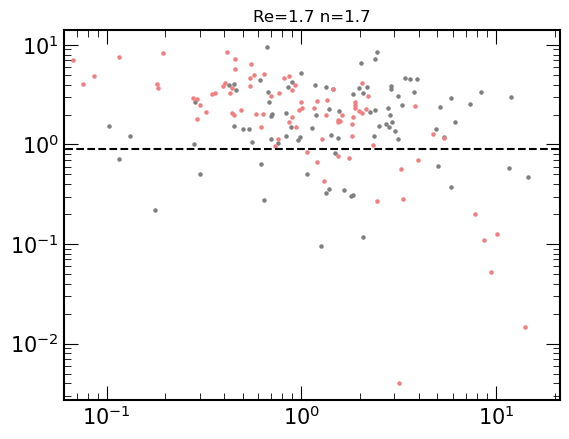

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.558550119400024
1.7 1.9
finished until t = 0.0 0.5810577869415283
finished until t = 0.5 4.483752489089966
finished until t = 1.0 11.691731452941895
finished until t = 1.5 22.301101207733154
finished until t = 2.0 36.436931848526
finished until t = 2.5 53.9492666721344
finished until t = 3.0 74.86678266525269
finished until t = 3.5 99.46574425697327
finished until t = 4.0 127.94653940200806
finished until t = 4.5 159.64182353019714
finished until t = 5.0 194.76459217071533
finished until t = 5.5 233.7198896408081
finished until t = 6.0 276.33847761154175
finished until t = 6.5 322.6176006793976
finished until t = 7.0 372.5330729484558
finished until t = 7.5 425.89305353164673
finished until t = 8.0 483.2486433982849
finished until t = 8.5 544.1598446369171
finished until t = 9.0 608.5594165325165
finished until t = 9.5 676.930543422699
finished until t = 10.0 749.4558277130127


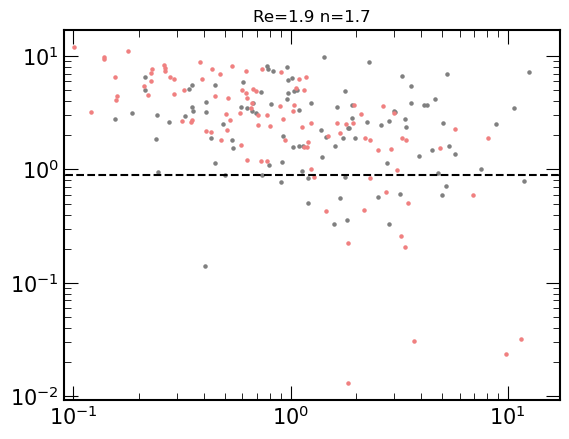

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
10.657705068588257
1.7 2.1
finished until t = 0.0 0.6031193733215332
finished until t = 0.5 4.756239891052246
finished until t = 1.0 12.456320762634277
finished until t = 1.5 23.754327058792114
finished until t = 2.0 38.594658851623535
finished until t = 2.5 56.966289043426514
finished until t = 3.0 78.83998823165894
finished until t = 3.5 104.05292224884033
finished until t = 4.0 133.04042077064514
finished until t = 4.5 165.81609725952148
finished until t = 5.0 202.3894784450531
finished until t = 5.5 242.29921960830688
finished until t = 6.0 285.95723247528076
finished until t = 6.5 333.4913504123688
finished until t = 7.0 384.51495575904846
finished until t = 7.5 439.5477089881897
finished until t = 8.0 498.31627106666565
finished until t = 8.5 560.8736536502838
finished until t = 9.0 629.274135351181
finished until t = 9.5 702.8430197238922
finished until t = 10.0 781.1333229541779


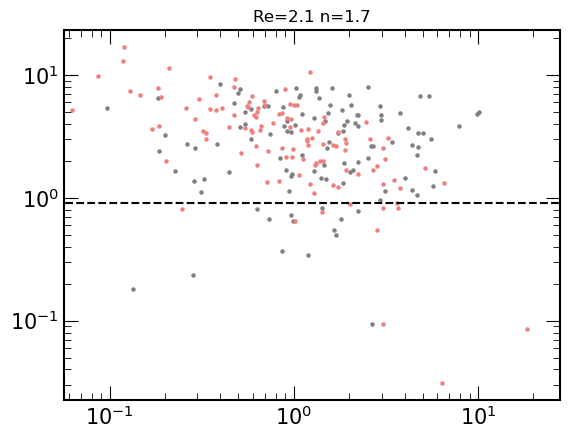

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
11.492697715759277
1.7 2.3
finished until t = 0.0 0.6071679592132568
finished until t = 0.5 4.566564559936523
finished until t = 1.0 12.298659801483154
finished until t = 1.5 23.2917902469635
finished until t = 2.0 38.03699541091919
finished until t = 2.5 56.42432880401611
finished until t = 3.0 78.22956442832947
finished until t = 3.5 100.6654839515686
finished until t = 4.0 126.01405811309814
finished until t = 4.5 154.1871199607849
finished until t = 5.0 185.90675950050354
finished until t = 5.5 220.23360776901245
finished until t = 6.0 258.2573401927948
finished until t = 6.5 300.7448134422302
finished until t = 7.0 345.7729687690735
finished until t = 7.5 395.3262197971344
finished until t = 8.0 449.45661330223083
finished until t = 8.5 504.6024284362793
finished until t = 9.0 563.4288992881775
finished until t = 9.5 625.4237780570984
finished until t = 10.0 690.6909387111664


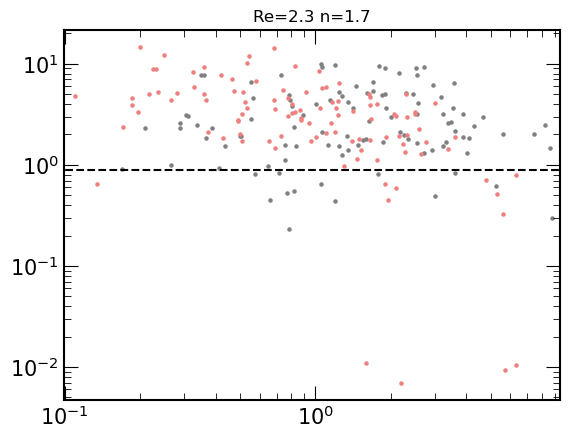

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
9.641067028045654
1.7 2.5
finished until t = 0.0 0.5362362861633301
finished until t = 0.5 4.024445295333862
finished until t = 1.0 10.27544093132019
finished until t = 1.5 19.447078943252563
finished until t = 2.0 31.72205352783203
finished until t = 2.5 46.68527269363403
finished until t = 3.0 64.34310865402222
finished until t = 3.5 84.78486013412476
finished until t = 4.0 106.78418612480164
finished until t = 4.5 131.47276496887207
finished until t = 5.0 159.2298128604889
finished until t = 5.5 189.5134847164154
finished until t = 6.0 222.54565024375916
finished until t = 6.5 257.9607536792755
finished until t = 7.0 296.27603554725647
finished until t = 7.5 337.2922067642212
finished until t = 8.0 381.0999882221222
finished until t = 8.5 427.89929819107056
finished until t = 9.0 477.2319378852844
finished until t = 9.5 529.1555354595184
finished until t = 10.0 583.7811472415924


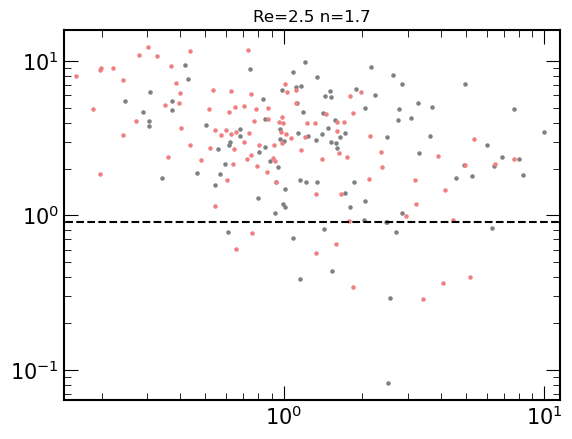

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.896383047103882
1.7 2.7
finished until t = 0.0 0.4832448959350586
finished until t = 0.5 3.81874680519104
finished until t = 1.0 10.382460594177246
finished until t = 1.5 19.34743618965149
finished until t = 2.0 31.52155041694641
finished until t = 2.5 46.47455596923828
finished until t = 3.0 64.37512183189392
finished until t = 3.5 85.30501580238342
finished until t = 4.0 109.37414455413818
finished until t = 4.5 136.31883239746094
finished until t = 5.0 166.1910469532013
finished until t = 5.5 199.68556928634644
finished until t = 6.0 235.89760446548462
finished until t = 6.5 275.1145906448364
finished until t = 7.0 317.6053874492645
finished until t = 7.5 362.79400300979614
finished until t = 8.0 411.5688626766205
finished until t = 8.5 463.902850151062
finished until t = 9.0 519.7977719306946
finished until t = 9.5 577.1313788890839
finished until t = 10.0 636.45028424263


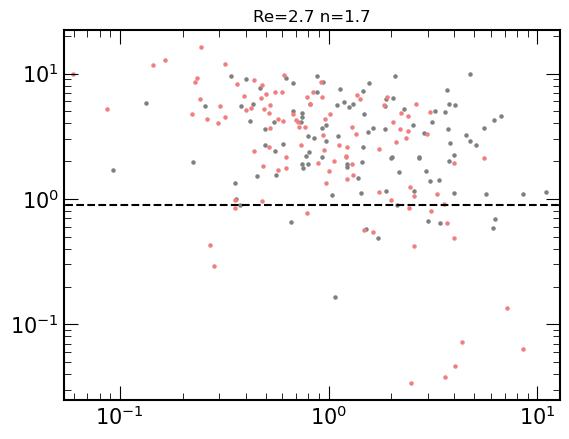

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.874185800552368
1.7 2.9
finished until t = 0.0 0.4077281951904297
finished until t = 0.5 2.961580991744995
finished until t = 1.0 7.965224504470825
finished until t = 1.5 15.445634841918945
finished until t = 2.0 25.176217317581177
finished until t = 2.5 37.3457567691803
finished until t = 3.0 52.219279050827026
finished until t = 3.5 69.50327038764954
finished until t = 4.0 89.46325898170471
finished until t = 4.5 111.41668105125427
finished until t = 5.0 136.00423669815063
finished until t = 5.5 162.69034218788147
finished until t = 6.0 192.51313281059265
finished until t = 6.5 224.5544719696045
finished until t = 7.0 259.36745834350586
finished until t = 7.5 296.4371953010559
finished until t = 8.0 336.8249611854553
finished until t = 8.5 379.86414551734924
finished until t = 9.0 425.4872007369995
finished until t = 9.5 474.156614780426
finished until t = 10.0 526.0863478183746


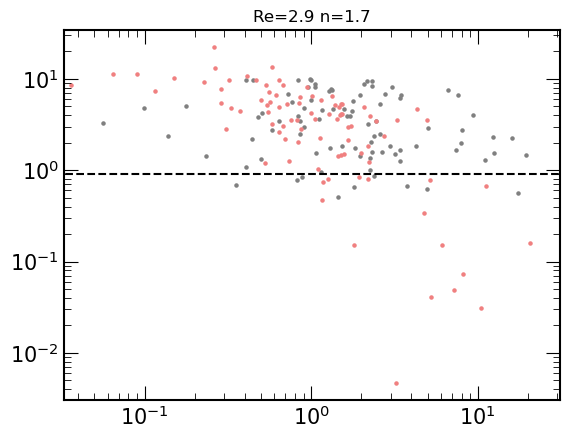

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.484653949737549
1.7 3.1
finished until t = 0.0 0.46257686614990234
finished until t = 0.5 3.4165165424346924
finished until t = 1.0 8.423596620559692
finished until t = 1.5 15.484865188598633
finished until t = 2.0 25.29957938194275
finished until t = 2.5 37.30741596221924
finished until t = 3.0 51.488064765930176
finished until t = 3.5 68.06416964530945
finished until t = 4.0 86.86072945594788
finished until t = 4.5 107.75214576721191
finished until t = 5.0 131.6634738445282
finished until t = 5.5 157.21290922164917
finished until t = 6.0 185.95447421073914
finished until t = 6.5 216.9940869808197
finished until t = 7.0 250.05253505706787
finished until t = 7.5 285.6758563518524
finished until t = 8.0 323.88836908340454
finished until t = 8.5 364.1300518512726
finished until t = 9.0 406.8841202259064
finished until t = 9.5 452.4219853878021
finished until t = 10.0 500.1306130886078


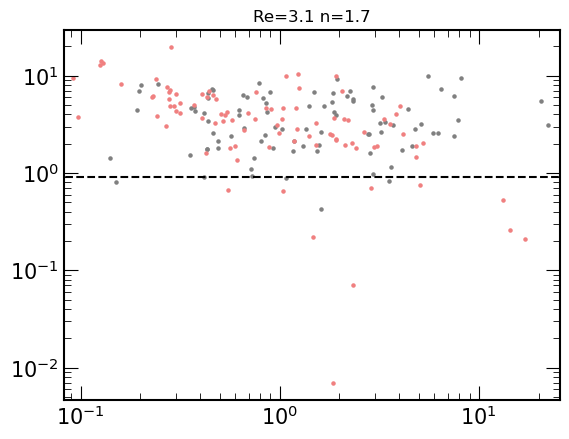

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.359406471252441
1.7 3.3
finished until t = 0.0 0.4684727191925049
finished until t = 0.5 3.541391611099243
finished until t = 1.0 8.808497667312622
finished until t = 1.5 16.405552625656128
finished until t = 2.0 26.753035068511963
finished until t = 2.5 39.58250331878662
finished until t = 3.0 54.74396014213562
finished until t = 3.5 72.33494853973389
finished until t = 4.0 92.3629777431488
finished until t = 4.5 115.46205401420593
finished until t = 5.0 140.48339176177979
finished until t = 5.5 168.58284401893616
finished until t = 6.0 199.44333577156067
finished until t = 6.5 232.89369869232178
finished until t = 7.0 268.80137276649475
finished until t = 7.5 307.82101035118103
finished until t = 8.0 349.19459414482117
finished until t = 8.5 393.6206750869751
finished until t = 9.0 440.968190908432
finished until t = 9.5 490.89068937301636
finished until t = 10.0 543.7588422298431


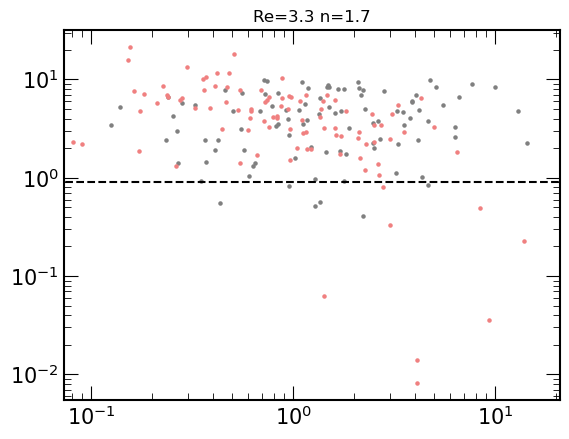

Calculating NFW Energies and Weights
Finished calculating NFW Energies and Weights
8.415480136871338
1.7 3.5
finished until t = 0.0 0.4402132034301758
finished until t = 0.5 3.391587257385254
finished until t = 1.0 8.82790994644165
finished until t = 1.5 16.225158214569092
finished until t = 2.0 26.57124090194702
finished until t = 2.5 39.21457290649414
finished until t = 3.0 54.133365869522095
finished until t = 3.5 71.45036935806274
finished until t = 4.0 91.07412195205688
finished until t = 4.5 113.08008408546448
finished until t = 5.0 137.964186668396
finished until t = 5.5 164.79960918426514
finished until t = 6.0 194.369380235672
finished until t = 6.5 226.4546070098877
finished until t = 7.0 261.17230248451233
finished until t = 7.5 298.18746519088745
finished until t = 8.0 337.4406633377075
finished until t = 8.5 379.70459246635437
finished until t = 9.0 424.50716519355774
finished until t = 9.5 471.47769045829773
finished until t = 10.0 521.5882790088654


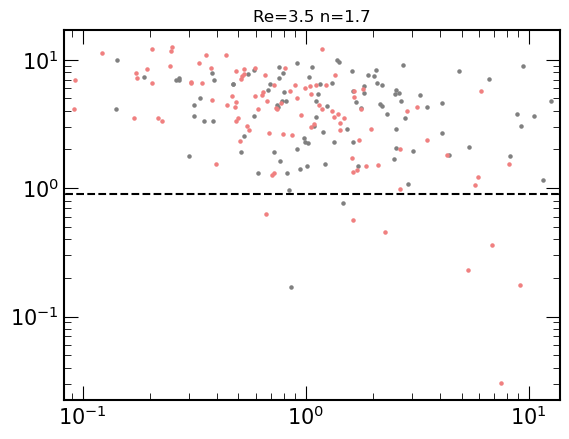

In [4]:
#NFW

n_values = [1.7]
R_e_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9, 2.1, 2.3, 2.5, 2.7, 2.9, 3.1, 3.3, 3.5]

for i in range(len(n_values)):
    n = n_values[i]
    for j in range (len(R_e_values)):
        R_e = R_e_values[j]
        
        # NFW ergodic distribution function, calling helpers from NFW_profile_functions.py
        ######################################
        # MAKE SURE THESE rho_0 and r_0 ARE THE SAME AS THE ONES IN THE ADDITIONAL_FORCES FILE
        ######################################

        rho_0_NFW = 17.99 # 10^5 solar masses / kpc^3
        r_0_NFW = 25.34 # kpc
        G = 0.449 # (kpc/Gyr)^2 * kpc / 10^5 solar masses
        Sersic_params_NFW = [R_e, n]
        @np.vectorize
        def NFW_ergodic_f(E):
            def integrand(psi):
                def r_psi(psi):
                    rootfinding_func = lambda r: np.abs(psi + phi_NFW(r, rho_0_NFW, r_0_NFW))  #lambda (def short function) arguments : expression
                    return minimize_scalar(rootfinding_func, method='bounded', bounds=[1e-20, 500]).x
                return np.sqrt(-E-psi)*d3rhodpsi3_NFW(r_psi(psi), rho_0_NFW, r_0_NFW, Sersic_params_NFW[0], Sersic_params_NFW[1])
            return 1/(np.sqrt(2)*np.pi**2) * quad(integrand, 0, -E)[0]

        start = time.time()
        print('Calculating NFW Energies and Weights')
        energy_values_NFW = 4 * np.pi * G * rho_0_NFW * r_0_NFW**2 * np.arange(-1+0.005, -0.005, 0.005)
        energy_weights_NFW = NFW_ergodic_f(energy_values_NFW)
        #E_dist_NFW = [energy_values_NFW, energy_weights_NFW]
        print('Finished calculating NFW Energies and Weights')
        print(time.time()-start)
        print(n, R_e)

        #making interpolated functions for f(E) that can be called in the initialization process for speed

        def NFW_f_interp(E):
            return 10**np.interp(E, energy_values_NFW, np.log10(energy_weights_NFW))
        
    
        #################################
        ## SAVES OUTPUTS FOR EVERY 0.5 Gyr

        def run_sim(potential, force, halo_params, ergodic_f, seed, t):
            start = time.time()
            np.random.seed(seed)

            # usual initialization of the sim, units, etc.
            sim = rebound.Simulation()
            sim.ri_ias15.epsilon = 0 # using fixed timesteps
            #sim.ri_ias15.min_dt = 1e-5
            #sim.ri_ias15.max_dt = 1e-3
            sim.dt = 5e-4 # fine to use this for quick tests, for the actual paper use the min & max above
            sim.G = 0.449 # setting units to kpc, Gyr, 10^5 M_sun
            sim.softening = 0.01 # plummer softening of 10 pc
            sim.collision = "line" # counting collisions as linear interpolations between timesteps
            sim.collision_resolve = merge_energy # conserving mass and momentum, with energy condition for mergers

            # Sersic radial distribution and values to draw positions with their weights

            pos_values = np.arange(1e-4, 10, 1e-4)
            pos_weights = nu(pos_values, R_e, n)*4*np.pi*pos_values**2
            pos_weights /= sum(pos_weights)

            # unpacking halo params
            rho_0 = halo_params[0]
            r_0 = halo_params[1]

            # setting up a mass function gaussian in logM
            logmass_values = np.linspace(-2, 2, 1000)
            logmass_weights = mass_function(logmass_values)
            logmass_weights /= sum(logmass_weights)

            total_GC_mass = 0
            # add particles w/ randomly drawn m, r, v until we reach the UGC7369 total GC mass
            while total_GC_mass < NGC4605_total_mass-10**(4.987311450993631 - 5):
                mass = np.exp(10/23) * 10**np.random.choice(logmass_values, p=logmass_weights) #random value is sampled from the logmass_values array with probabilities defined by the logmass_weights
                pos_rad = np.random.choice(pos_values, p=pos_weights)
                pos_theta = np.random.uniform(0, np.pi)
                pos_phi = np.random.uniform(0, 2*np.pi)
                x_i = pos_rad*np.sin(pos_theta)*np.cos(pos_phi)  #Cartesian coordinates
                y_i = pos_rad*np.sin(pos_theta)*np.sin(pos_phi)
                z_i = pos_rad*np.cos(pos_theta)

                # drawing velocities from provided distribution
                vel_values = np.arange(0.01, 100, 0.01)
                vel_weights = 4*np.pi*vel_values**2 * \
                                ergodic_f(0.5*vel_values**2 + potential(pos_rad, rho_0, r_0))/(nu(pos_rad, R_e, n))
                vel_weights /= sum(vel_weights)
                vel_mag = np.random.choice(vel_values, p=vel_weights)
                v_theta = np.random.uniform(0, np.pi)
                v_phi = np.random.uniform(0, 2*np.pi)
                vx_i = vel_mag * np.sin(v_theta)*np.cos(v_phi)
                vy_i = vel_mag * np.sin(v_theta)*np.sin(v_phi)
                vz_i = vel_mag * np.cos(v_theta)

                sim.add(m = mass, r = 2*2.548e-3*(mass/0.1)**(0.242), \
                        x = x_i, y = y_i, z = z_i, vx = vx_i, vy = vy_i, vz = vz_i)
                total_GC_mass += mass/np.exp(10/23)

            rebx = reboundx.Extras(sim)
            # adding in the additional forces to work with reboundx
            myforce = rebx.create_force("additional_forces")
            myforce.force_type = "vel"
            myforce.update_accelerations = force
            rebx.add_force(myforce)
            # setting up built-in exponential mass loss
            modifymass = rebx.load_operator("modify_mass")
            rebx.add_operator(modifymass)
            # setting the mass-loss timescales of each particle, tau chosen to match linear decrease of 1/3 by end
            for p in sim.particles:
                p.params["tau_mass"] = -23

            # keeping track of initial positions, velocities, and masses
            initial_masses = []
            initial_positions = []
            initial_vels = []

            for p in sim.particles:
                initial_masses.append(p.m)
                initial_positions.append(np.array([p.x, p.y, p.z]))
                initial_vels.append(np.array([p.vx, p.vy, p.vz]))

            # integrating
            sim.integrate(t)

            # keeping track of final positions, velocities, and masses
            final_masses = []
            final_positions = []
            final_vels = []

            for p in sim.particles:
                final_masses.append(p.m)
                final_positions.append(np.array([p.x, p.y, p.z]))
                final_vels.append(np.array([p.vx, p.vy, p.vz]))

            initial_masses, final_masses = np.array(initial_masses), np.array(final_masses)
            initial_positions, final_positions = np.array(initial_positions), np.array(final_positions)
            initial_vels, final_vels = np.array(initial_vels), np.array(final_vels)

            # clearing sim from memory now that we've stored everything important
            sim = None

            # returning 3 sets of 2 things: the initial and final masses, positions, and velocities
            return [initial_masses, final_masses], [initial_positions, final_positions], [initial_vels, final_vels]
        
        ###############################################################################
        ## run N_iterations versions of the sim, outputting every 0.5 Gyrs for 10 Gyrs

        def run_iterations(N_iterations, output_name, potential, force, halo_params, ergodic_f):
            seeds = np.random.randint(1, 4294967295, size = N_iterations)

            start = time.time()

            for output_time, t in enumerate(np.arange(0, 10.5, 0.5)):

                if output_time == 0:
                    # save initial data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=0.001)
                        for GC_n in range(len(masses[0])):
                            f.write(str(k)+' '+str(masses[0][GC_n])+' '+str(positions[0][GC_n][0])+' '\
                                    +str(positions[0][GC_n][1])+' '+str(positions[0][GC_n][2])+' '\
                                    +str(velocities[0][GC_n][0])+' '+str(velocities[0][GC_n][1])+' '\
                                    +str(velocities[0][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                else:
                    # save final data
                    f = open('Sim_n_'+str(n)+'_'+output_name+'_'+str(output_time)+'_'+str(R_e)+'.txt', 'w')
                    f.write('t = '+str(t)+' Gyr \n')
                    f.write('iteration m x y z vx vy vz n Re \n')
                    for k in range(N_iterations):
                        seed = seeds[k]
                        masses, positions, velocities = run_sim(potential = potential, force = force, \
                                                                halo_params = halo_params, ergodic_f = ergodic_f, \
                                                                seed = seed, t=t)
                        for GC_n in range(len(masses[1])):
                            f.write(str(k)+' '+str(masses[1][GC_n])+' '+str(positions[1][GC_n][0])+' '\
                                        +str(positions[1][GC_n][1])+' '+str(positions[1][GC_n][2])+' '\
                                        +str(velocities[1][GC_n][0])+' '+str(velocities[1][GC_n][1])+' '\
                                        +str(velocities[1][GC_n][2])+' '+str(n)+' '+str(R_e)+'\n')
                    f.close()
                print('finished until t = '+str(t), str(time.time()-start))

        ##############################################
        #RUNS EVERYTHING 
        
        run_iterations(10, 'ZoomNFW-3', phi_NFW, clib_additional_forces.NFW_DF_Petts, [17.99, 25.34], NFW_f_interp)
        data_initial = np.genfromtxt('Sim_n_'+str(n)+'_ZoomNFW-3_0'+'_'+str(R_e)+'.txt', skip_header=2)
        initial_masses = data_initial[:, 1]
        initial_radii = np.sqrt(data_initial[:, 2]**2 + data_initial[:, 3]**2 + data_initial[:, 4]**2)
        data_final = np.genfromtxt('Sim_n_'+str(n)+'_ZoomNFW-3_20'+'_'+str(R_e)+'.txt', skip_header=2)
        final_masses = data_final[:, 1]
        final_radii = np.sqrt(data_final[:, 2]**2 + data_final[:, 3]**2 + data_final[:, 4]**2)
        
        plt.plot([1e-2, 1e2], [0.9, 0.9], 'k--')
        plt.scatter(initial_masses, initial_radii, color='gray', s=5)
        plt.scatter(final_masses, final_radii, color='lightcoral', s=5)
        #plt.scatter(UGC7369_masses, UGC7369_rperps, color='b', s=5)
        plt.yscale('log')
        plt.xscale('log')
        plt.xlim(min(final_masses)*0.9, max(final_masses)*1.5)
        plt.title('Re='+str(R_e)+' n='+str(n))
        plt.savefig('ZoomNFW-3_'+str(n)+'_'+str(R_e)+'.png')
        plt.show()
        
             